In [13]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat

MTsat, R1, MD, R2, MTV, R2s = 0, 1, 2, 3, 4, 5


def generate_beta(max_value = 20000, length = 800):
    beta_values = [max_value]
    for idx in range(length-1):
        beta_values.append(beta_values[-1]*0.99)
    return beta_values[::-1]


def D_kl(p1, p2):
    C1 = np.einsum('ij,ik->ijk', p1, 1 / p2)  ###is it the right way?
    # print(C1)
    C2 = np.log(C1)
    # print(C2)
    C2[p1 == 0, :] = 0
    # print(C2)
    return np.einsum('ij,ijk->jk', p1, C2)


def D_kl_vec(p_y_x_hat):
    Dkl_vals = []
    for idx in range(p_y_x_hat.shape[1]):
        p_mean = np.mean(p_y_x_hat, axis=1)
        p_cur = p_y_x_hat[:, idx]
        dkl = sum([p_cur[x] * np.log(p_cur[x] / p_mean[x]) if (p_cur[x] > 0) else 0 for x in range(p_y_x_hat.shape[0])])
        # dkl = -sum([p_mean[x]*np.log(p_cur[x]/p_mean[x]) if (p_mean[x] > 0 and p_cur[x] > 0) else 0 for x in range(33)])
        Dkl_vals.append(dkl)
    return Dkl_vals


def load_data(path):
    x = loadmat(path)
    mean_values = {}
    subjects = {}
    region = {}

    with open('C:\\Users\\nitai seri\\Desktop\\study\\university\\year3\\Lab\\IB-for-MRI\\gender.txt') as f:
        gender = f.read().splitlines()
    with open('C:\\Users\\nitai seri\\Desktop\\study\\university\\year3\\Lab\\IB-for-MRI\\age.txt') as f:
        age = f.read().splitlines()
    with open('C:\\Users\\nitai seri\\Desktop\\study\\university\\year3\\Lab\\IB-for-MRI\\area_names2.txt') as f:
        area_names = f.read().splitlines()
    with open('C:\\Users\\nitai seri\\Desktop\\study\\university\\year3\\Lab\\IB-for-MRI\\area_types.txt') as f:
        area_types = f.read().splitlines()

    subj_id = [str(x + 1) for x in range(45)]
    sub = np.array(list(zip(subj_id, age, gender)))

    for ix in range(6):
        subjects[ix] = sub.copy()
        mean_values[ix] = x['huji_data']['data'][0][0][:, :, ix]

        mean_values[ix] = np.delete(mean_values[ix], 29, 0)  # remove Left Accumbens
        mean_values[ix] = np.delete(mean_values[ix], 20, 0)  # remove Medulla
        mean_values[ix] = np.delete(mean_values[ix], 8, 0)  # remove Right Accumbens

        subjects[ix] = subjects[ix][~np.isnan(mean_values[ix].T).any(axis=1)]
        mean_values[ix] = (mean_values[ix].T[~np.isnan(mean_values[ix].T).any(axis=1)]).T

    del area_names[29]  # remove Left Accumbens
    del area_names[20]  # remove Medulla
    del area_names[8]  # remove Right Accumbens
#     print(len(area_names))
#     for ix in range(6):
#         print(subjects[ix].shape)
#         print(mean_values[ix].shape)

    del area_types[29]  # remove Left Accumbens
    del area_types[20]  # remove Medulla
    del area_types[8]  # remove Right Accumbens
    for x, y in zip(area_names, area_types):
        region[x] = y
    return mean_values, subjects, region, area_names, area_types

In [14]:
class IB:
    def __init__(self, input_matrix, beta_values, subjects, regions, analyse_by_areas, area_names, area_types):
        self.beta_values = beta_values
        self.analyse_by_areas = analyse_by_areas
        self.region = regions
        self.subjects = subjects
        self.input_matrix = input_matrix
        self.p_y_x_hat = None
        self.p_x_given_x_hat = None
        self.clusters_matrix = []
        self.full_distances = []
        self.clus = []
        self.area_names = area_names
        self.area_types = area_types

    def IB_iter(self, p_x, p_y_x, p_x_hat_given_x, beta):
        if beta < 2800:
            # set_trace()
            pass
        p_x_hat = p_x_hat_given_x @ p_x
        p_x_given_x_hat = (p_x_hat_given_x * p_x).T / (p_x_hat)
        # p_x_given_x_hat[np.isnan(p_x_given_x_hat)] = 0
        p_y_x_hat = p_y_x @ p_x_given_x_hat
        not_norm = np.exp(-beta * D_kl(p_y_x, p_y_x_hat)) * p_x_hat
        not_norm = not_norm.T
        return not_norm / np.sum(not_norm, axis=0)

    def prepare_prob(self, input_matrix):
        # input_matrix = abs(np.random.normal(2,1,(5,8)))
        p_y_x = input_matrix / np.sum(input_matrix, axis=0)

        x_dim = p_y_x.shape[1]
        p_x = np.ones(x_dim)
        p_x = p_x / np.sum(p_x)

        p_x_hat_given_x = np.eye(x_dim) + abs(np.random.normal(0, 0.02, (x_dim, x_dim)))
        p_x_hat_given_x = p_x_hat_given_x / np.sum(p_x_hat_given_x, axis=0)

        return p_y_x, p_x, p_x_hat_given_x

    def get_clusters(self):
        p_y_x, p_x, p_x_hat_given_x = self.prepare_prob(self.input_matrix)

        self.beta_values = self.beta_values[::-1]

        for beta in self.beta_values:
            err = 1
            # while err > 1e-7:
            while err > (1 / beta) / 10:
                prev_p = p_x_hat_given_x
                p_x_hat_given_x = self.IB_iter(p_x, p_y_x, p_x_hat_given_x, beta)
                err = np.sum(abs(prev_p - p_x_hat_given_x))

            p_x_hat = p_x_hat_given_x @ p_x
            p_x_given_x_hat = (p_x_hat_given_x * p_x).T / (p_x_hat)

            p_y_x_hat = p_y_x @ p_x_given_x_hat
            self.full_distances.append(D_kl_vec(p_y_x_hat))
            # self.clus.append(np.linalg.matrix_rank(p_y_x_hat, tol = 1e-7))
            # print(beta, np.linalg.matrix_rank(p_y_x_hat, tol = 1e-7))
            self.clus.append(np.linalg.matrix_rank(p_y_x_hat, tol=(1 / beta) / 10))
            # print(beta, np.linalg.matrix_rank(p_y_x_hat, tol = (1/beta)/10))
            t, indices = np.unique(p_x_given_x_hat.round(decimals=int(np.ceil(np.log10(10 * beta)))), axis=1,
                                   return_inverse=True)
            self.clusters_matrix.append(indices)
            # print(beta)
        # print(self.clusters_matrix)
        self.p_y_x_hat = p_y_x_hat
        self.p_x_given_x_hat = p_x_given_x_hat

    def run_analysis(self):
        #contrast = type
        #analyse_areas- if False, analyse subjects (take transpose of the matrix)

        # input_matrix = np.exp(mean_values[contrast]**2)
        # input_matrix = np.exp(-1/mean_values[contrast])  ###for MTV
        # input_matrix = mean_values[contrast]**4  ###for R2s
        # input_matrix = np.exp(-1/mean_values[contrast]**2)  ###for MD

        if self.analyse_by_areas:
            self.input_matrix = self.input_matrix.T
        self.get_clusters()

        print("Done")

In [22]:
## Plot results:
def subj_to_text(subj):
    #return 'ID: ' + subj[0] + ' Age: ' + subj[1] + ' ' + subj[2]
    return 'Age: ' + subj[1] + ' (' + subj[2] + ')'


def plot_results(ib_d):
    #plot_axis = [1, max(beta_values), 0,max(max(full_distances))*1.10]
    plot_axis = [200, 6000, 0,0.005]
    #plot_axis = [1000, 5000, 0,0.015]

    # plot bifrucation diagram:
    plt.figure(figsize=(30,30))
    plt.rcParams["figure.figsize"]=30,30
    fd = np.array(ib_d.full_distances)

    ## separate white:
    #for idx in range(fd.shape[1]):
        #if 'wm' in area_names[idx] or 'White' in area_names[idx] or area_names[idx] == 'CC':
        #if 'ctx' in area_names[idx]:
    #        fd[:500,idx] = -fd[:500,idx]

    for idx in range(fd.shape[1]):
        plt.plot(ib_d.beta_values[::-1],fd[:,idx],linewidth=3)

    #plot legend
    for idx in range(ib_d.p_y_x_hat.shape[1]):
        text_condition = fd[0,idx] < plot_axis[3]
        text_condition = True
        if not(fd[0,idx] == np.inf):
            if text_condition:
                if ib_d.analyse_by_areas:
                    plt.text(plot_axis[1]*1.05, fd[0,idx],ib_d.area_names[idx],fontsize=15) #,rotation=45,rotation_mode = "anchor")
                else:
                    plt.text(plot_axis[1]*1.05, fd[0,idx],subj_to_text(ib_d.subjects[idx]),fontsize=15) #,rotation=45,rotation_mode = "anchor")

    plt.title('R2s')
    plt.xscale("log")
    plt.xlabel('beta')
    plt.ylabel('Dkl to mean')
    plt.axis(plot_axis)
    #plt.savefig('C:\\Users\\nitai seri\\Desktop\\study\\university\\year3\\Lab\\IB-for-MRI\\MTV.png')


In [16]:
input_matrixes, subjects, regions, area_names, area_types = load_data('C:\\Users\\nitai seri\\Desktop\\study\\university\\year3\\Lab\\IB-for-MRI\\huji_data.mat')
beta_values = generate_beta(10000, 800)
print(np.max(input_matrixes[MTV]))
print(np.min(input_matrixes[MTV]))
print(np.max(beta_values))
print(np.min(beta_values))

0.3448758125305176
0.1581858992576599
10000.0
3.254771342224589


In [17]:
ib_data = IB(input_matrixes[MTV], beta_values, subjects[MTV], regions, True, area_names, area_types)


In [18]:
ib_data.run_analysis()

Done


In [26]:
fd = np.array(ib_data.full_distances)
print(fd[:,0])

[ 2.07669221e-04  2.05996738e-04  2.04230643e-04  2.02364667e-04
  2.00391897e-04  1.98304682e-04  1.96094504e-04  1.93751835e-04
  1.91266566e-04  1.88633891e-04  1.85794682e-04  1.82840996e-04
  1.79683375e-04  1.76060680e-04  1.72420202e-04  1.68508556e-04
  1.64264229e-04  1.59629596e-04  1.54526742e-04  1.48845290e-04
  1.42419203e-04  1.34978118e-04  1.26039366e-04  1.15368328e-04
  1.06844941e-04  9.97184664e-05  9.36897922e-05  8.56948581e-05
  5.84180745e-05  5.24822251e-05  4.94632913e-05  4.69101779e-05
  4.45968594e-05  4.30662337e-05  4.18321124e-05  4.07986597e-05
  3.99016472e-05  3.90969333e-05  3.83690569e-05  3.73424217e-05
  3.66739607e-05  3.74012209e-05  3.70360182e-05  3.67092975e-05
  3.64700933e-05  3.62293929e-05  3.59852577e-05  3.59049260e-05
  3.59223218e-05  3.59322257e-05  3.58066997e-05  3.56985912e-05
  3.56118136e-05  3.55502191e-05  3.55181023e-05  3.55133368e-05
  3.54324843e-05  3.71063328e-05  3.70022398e-05  3.68885302e-05
  3.67783817e-05  3.66722

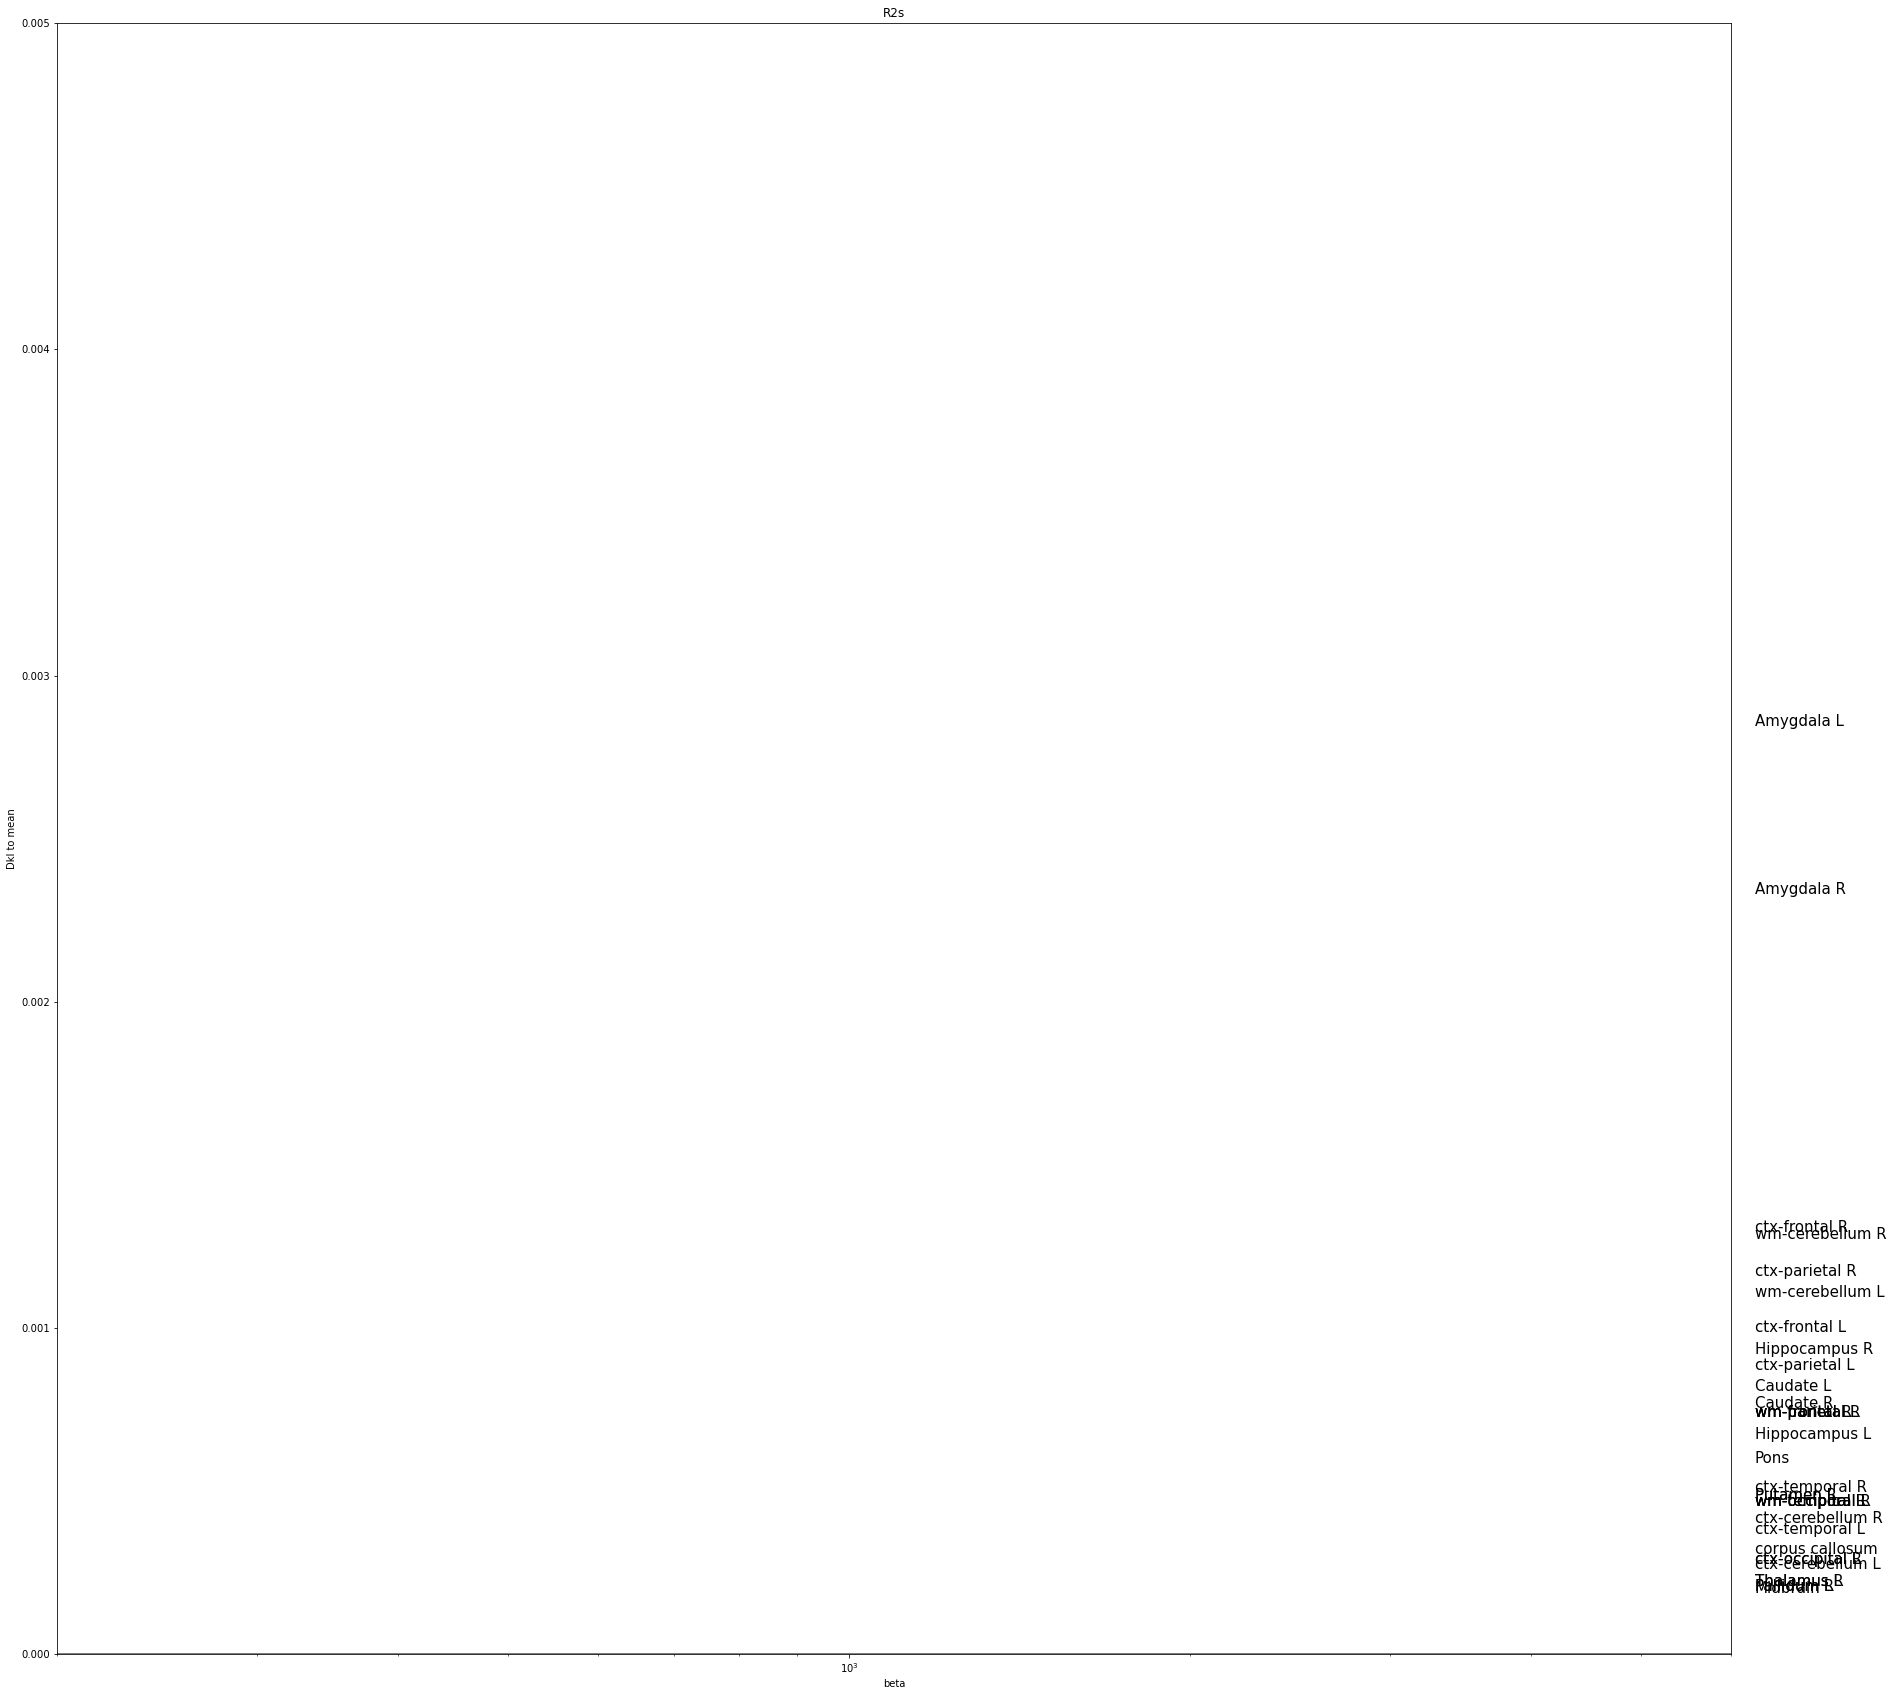

In [27]:

plot_results(ib_data)